In [2]:
from collections import OrderedDict

import numpy as np
import nni
import torch

import nni.retiarii.nn.pytorch as nn
import pytorch_lightning as pl

from nni import trace
from nni.retiarii import model_wrapper
from nni.retiarii.nn.pytorch import Cell
from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig
from nni.retiarii.strategy import DARTS as DartsStrategy
from nni.retiarii.evaluator.pytorch import Lightning, LightningModule, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.utilities.types import STEP_OUTPUT

from torch import optim, tensor, zeros_like
from typing import Any

from darts.common_utils import *
from darts.early_stop import MSE
from darts.noises import add_selected_noise
from darts.phantom import generate_phantom

from torch.utils.data import Dataset

/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/lightning/fabric/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/

# space

In [14]:
def conv_2d(C_in, C_out, kernel_size=3, dilation=1, padding=1, activation=None):
    return nn.Sequential(
        nn.Conv2d(C_in, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation,
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation
    )

def depthwise_separable_conv(C_in, C_out, kernel_size=3, dilation=1, padding=1, activation=None):
    return nn.Sequential(
        nn.Conv2d(C_in, C_in, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_in, bias=False),
        nn.Conv2d(C_in, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation,
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_out, bias=False),
        nn.Conv2d(C_out, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation
    )

def maxpool_2d_conv2d(C_in, C_out):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        conv_2d(C_in, C_out)
        )

def maxpool_2d_depthwise_separable_conv(C_in, C_out):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        depthwise_separable_conv(C_in, C_out)
        )

def avgpool_2d_conv2d(C_in, C_out):
    return nn.Sequential(
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        conv_2d(C_in, C_out)
        )

def avgpool_2d_depthwise_separable_conv(C_in, C_out):
    return nn.Sequential(
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        depthwise_separable_conv(C_in, C_out)
        )

def nearest_upsample_conv2d(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='nearest'),
        conv_2d(C_in, C_out)
        )

def nearest_upsample_depthwise_separable_conv(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='nearest'),
        depthwise_separable_conv(C_in, C_out)
        )

def bilinear_upsample_conv2d(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
        conv_2d(C_in, C_out)
        )

def bilinear_upsample_depthwise_separable_conv(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
        depthwise_separable_conv(C_in, C_out)
        )

def encoder_ops(C_in,C_out):
    return [
    maxpool_2d_conv2d(C_in, C_out),
    maxpool_2d_depthwise_separable_conv(C_in, C_out),
    avgpool_2d_conv2d(C_in, C_out),
    avgpool_2d_depthwise_separable_conv(C_in, C_out)
]

def decoder_ops(C_in,C_out):
    return [
    nearest_upsample_conv2d(C_in, C_out),
    nearest_upsample_depthwise_separable_conv(C_in, C_out),
    bilinear_upsample_conv2d(C_in, C_out),
    bilinear_upsample_depthwise_separable_conv(C_in, C_out)
]

def pools():
    return [
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
    ]

def upsamples():
    return [
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Upsample(scale_factor=2, mode='bilinear'),
        # nn.Upsample(scale_factor=2, mode='trilinear'),
    ]

def convs(C_in, C_out):
    return [
        # nn.Conv2d(C_in, C_out, kernel_size=3, padding=1),
        # nn.Conv2d(C_in, C_out, kernel_size=1, padding=0),
        conv_2d(C_in, C_out),
        conv_2d(C_in, C_out, activation=nn.SiLU()),
        conv_2d(C_in, C_out, activation=nn.Sigmoid()),
        depthwise_separable_conv(C_in, C_out),
        depthwise_separable_conv(C_in, C_out, activation=nn.SiLU()),
        depthwise_separable_conv(C_in, C_out, activation=nn.Sigmoid()),
    ]

class Preprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, 1)

    def forward(self, x):
        return [self.conv1(x[0])]

class Postprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)

    def forward(self, x):
        return [self.conv1(x[0]), self.conv2(x[1])]

@model_wrapper
class DARTS_UNet(nn.Module):
    def __init__(self, C_in=1, C_out=1, depth=4):
        super().__init__()

        # all padding should follow this formula:
        # pd = (ks - 1) * dl // 2
        self.pr = False
        self.depth = depth
        
        self.in_layer = nn.Conv2d(C_in, 64, kernel_size=3, padding=1)

        # Encoders
        filters = 64
        self.encoders = nn.ModuleList()
        for i in range(depth):
            self.encoders.append(Cell(pools(), num_nodes=1, num_ops_per_node=2, num_predecessors=1))
            self.encoders.append(Cell(convs(filters, filters*2), num_nodes=1, num_ops_per_node=2, num_predecessors=1))
            filters *= 2

        # Decoders
        self.decoders = nn.ModuleList()
        for i in range(depth):
            self.decoders.append(Cell(upsamples(), num_nodes=1, num_ops_per_node=2, num_predecessors=1))
            filters //= 2
            self.decoders.append(Cell(convs(filters*3, filters), num_nodes=1, num_ops_per_node=2, num_predecessors=1))

        self.out_layer = nn.Conv2d(64, C_out, kernel_size=3, padding=1)

    def forward(self, x):

        if self.pr:
            print(f'input shape: {x.shape}\n')

        x = self.in_layer(x)  # Apply the initial layer
        skip_connections = [x]

        for i in range(self.depth):
            x = self.encoders[2*i]([x])
            x = self.encoders[2*i+1]([x])
            skip_connections.append(x)

        for i in range(self.depth):
            upsampled = self.decoders[2*i]([x])
            cropped = self.crop_tensor(upsampled, skip_connections[-(i+2)])
            x = torch.cat([cropped, upsampled], 1)
            x = self.decoders[2*i+1]([x])

        x = self.out_layer(x)  # Apply the final layer

        return x

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    
    def test(self):
        """
        This will input a random tensor of 1x1x128x128 and test the forward pass.
        """
        self.pr = True
        x = torch.randn(1, 1, 128, 128)
        y = self.forward(x)
        assert y.shape == (1, 1, 128, 128), "Output shape should be (1, 1, 128, 128), got {}".format(y.shape)
        print(f'output shape: {y.shape}\n')
        print("Test passed.\n\n")

model = DARTS_UNet(1, 1)
model.test()


input shape: torch.Size([1, 1, 128, 128])

output shape: torch.Size([1, 1, 128, 128])

Test passed.




# eval

In [15]:
class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary??)
        return self.image

@trace
class LightningEvalSearch(LightningModule):
    def __init__(self, phantom=None, buffer_size=100, num_iter=50,
                lr=0.00005, noise_type='gaussian', noise_factor=0.15, resolution=6, 
                n_channels=1, reg_noise_std_val=1./30.):
        super().__init__()

        # input
        self.phantom = phantom

        # Loss
        self.criterion = nn.MSELoss().to(self.device)
        
        # Hyperparameters / Inputs
        self.buffer_size = buffer_size
        self.num_iter = num_iter
        self.lr = lr
        self.noise_type = noise_type
        self.noise_factor = noise_factor
        self.resolution = resolution
        self.n_channels = n_channels
        self.reg_noise_std = tensor(reg_noise_std_val)

        # adjusting input
        if self.phantom is None:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor)
        else:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor, input_img_np=self.phantom)
        self.net_input = get_noise(input_depth=1, spatial_size=self.img_np.shape[1], noise_type=self.noise_type)
        
        # History and early stopper
        self.loss_history = []
        self.variance_history = []
        self.img_collection = []
        
    def forward(self, net_input):
        net_input_perturbed = net_input + zeros_like(net_input).normal_(std=self.reg_noise_std)
        return self.model(net_input_perturbed)
    
    def training_step(self, batch, batch_idx):
        """
        Deep Image Prior

        training here follows closely from the following two repos: 
            - the deep image prior repo
            - a DIP early stopping repo (Lighting has early stopping functionality so this blends the two)
        """        

        r_img_torch = self.forward(self.net_input)
        r_img_np = torch_to_np(r_img_torch)

        # update loss and loss history
        total_loss = self.criterion(r_img_torch, self.img_noisy_torch)
        self.loss_history.append(total_loss.item())
        self.logger.log_metrics({'loss': total_loss.item()})

        # Using global_step to count iterations
        iterator = self.global_step

        # update img collection
        r_img_np = r_img_np.reshape(-1)
        self.update_img_collection(r_img_np)
        img_collection = self.get_img_collection()

        # if len(img_collection) == self.buffer_size:
        if len(img_collection) >= self.buffer_size // 2:

            # update variance and var history
            ave_img = np.mean(img_collection, axis=0)
            variance = [MSE(ave_img, tmp) for tmp in img_collection]
            self.cur_var = np.mean(variance)
            self.variance_history.append(self.cur_var)

            # update log
            self.latest_loss = total_loss.item()
            self.log('variance', self.cur_var)
            self.log('loss', self.latest_loss)
            nni.report_intermediate_result({'Iteration':iterator,'variance':self.cur_var, 'loss': self.latest_loss})

        return {"loss": total_loss}

    def configure_optimizers(self):
        """
        Basic Adam Optimizer
        """
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer
    
    def optimizer_zero_grad(self, epoch, batch_idx, optimizer, opt_idx):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        optimizer.zero_grad()
    
    def configure_gradient_clipping(self, optimizer, opt_idx, gradient_clip_val, gradient_clip_algorithm):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        # now need to define the clipping logic
        self.clip_gradients(
            optimizer,
            gradient_clip_val=gradient_clip_val,
            gradient_clip_algorithm=gradient_clip_algorithm
        )

    def set_model(self, model):
        # This will be called after __init__ and will set the candidate model
        # needed for NAS but not 
        self.model = model
    
    def train_dataloader(self):
        """
        Dummy DataLoader that returns nothing but makes PyTorch Lightning's training loop work
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    def on_train_start(self):
        """
        Move all tensors to the GPU to begin training
        """
        self.model.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)

    def on_train_end(self, **kwargs: Any):
        """
        Report final PSNR to NNI and display the results
        """

        # final log
        # self.logger.log_metrics({'variance':self.cur_var, 'loss': self.latest_loss})
        # nni.report_final_result({'variance':self.cur_var, 'loss': self.latest_loss})

        # plot images to see results
        denoised_img = self.forward(self.net_input).detach().cpu().squeeze().numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))

        ax[0].imshow(self.img_np.squeeze(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(denoised_img, cmap='gray')
        ax[1].set_title("Denoised Image")
        ax[1].axis('off')

        ax[2].imshow(self.img_noisy_torch.detach().cpu().squeeze().numpy(), cmap='gray')
        ax[2].set_title("Noisy Image")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

    # def test_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     pass

    def val_dataloader(self):
        """
        Dummy DataLoader for validation.
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    # def validation_step(self, trainer, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     # if self.buffer_size == len(self.img_collection):
    #     #     self._run_early_stopping_check(trainer)
    #     pass

    def update_img_collection(self, cur_img):
        self.img_collection.append(cur_img)
        if len(self.img_collection) > self.buffer_size:
            self.img_collection.pop(0)

    def get_img_collection(self):
        return self.img_collection

    def preprocess_image(self, resolution, noise_type, noise_factor, input_img_np=None):
        """
        Generates an image (or takes an input phantom), adds noise, and converts it to both numpy and torch tensors.

        Args:
        - resolution (int): Resolution for the phantom image.
        - noise_type (str): Type of noise to add.
        - noise_factor (float): Noise factor.
        - input_img_np (numpy.ndarray, optional): Input raw image in numpy format. If not provided, a new image will be generated.

        Returns:
        - img_np (numpy.ndarray): Original image in numpy format.
        - img_noisy_np (numpy.ndarray): Noisy image in numpy format.
        - img_torch (torch.Tensor): Original image in torch tensor format.
        - img_noisy_torch (torch.Tensor): Noisy image in torch tensor format.
        """
        if input_img_np is None:
            raw_img_np = generate_phantom(resolution=resolution) # 1x64x64 np array
        else:
            raw_img_np = input_img_np.copy() # 1x64x64 np array
            
        img_np = raw_img_np.copy() # 1x64x64 np array
        img_torch = torch.tensor(raw_img_np, dtype=torch.float32).unsqueeze(0) # 1x1x64x64 torch tensor
        img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor) # 1x1x64x64 torch tensor
        img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 1x64x64 np array
        
        return img_np, img_noisy_np, img_torch, img_noisy_torch

class _EarlyStopping(EarlyStopping, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

# submit search

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 195 M 
----------------------------------------------
195 M     Trainable params
0         Non-trainable params
195 M     Total params
780.736   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[2023-08-23 06:43:24] Intermediate result: {"Iteration": 0, "variance": 0.04188824054785073, "loss": 0.017314046621322632}  (Index 0)
[2023-08-23 06:43:25] Intermediate result: {"Iteration": 0, "variance": 0.04134502207093379, "loss": 0.01661338284611702}  (Index 1)
[2023-08-23 06:43:25] Intermediate result: {"Iteration": 0, "variance": 0.04081203542255725, "loss": 0.01651301421225071}  (Index 2)
[2023-08-23 06:43:25] Intermediate result: {"Iteration": 0, "variance": 0.04026714375875187, "loss": 0.016236184164881706}  (Index 3)
[2023-08-23 06:43:26] Intermediate result: {"Iteration": 0, "variance": 0.0397312562585015, "loss": 0.016277797520160675}  (Index 4)
[2023-08-23 06:43:26] Intermediate result: {"Iteration": 0, "variance": 0.03918663964352825, "loss": 0.015837296843528748}  (Index 5)
[2023-08-23 06:43:26] Intermediate result: {"Iteration": 0, "variance": 0.03865721138260726, "loss": 0.01601659692823887}  (Index 6)
[2023-08-23 06:43:27] Intermediate result: {"Iteration": 0, "varia

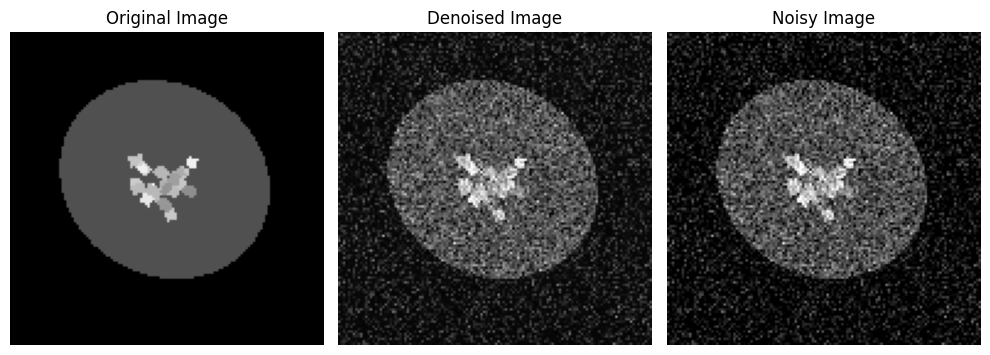

In [11]:

# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=100,
                num_iter=50,
                lr=0.00005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            callbacks=[early_stop_callback],
            max_epochs=3000, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=False,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

In [27]:
experiment.stop()

[2023-08-23 07:50:38] Stopping experiment, please wait...
[2023-08-23 07:50:38] Experiment stopped


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 209 M 
----------------------------------------------
209 M     Trainable params
0         Non-trainable params
209 M     Total params
837.594   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[2023-08-23 07:39:07] Intermediate result: {"Iteration": 0, "variance": 0.47561948612332344, "loss": 0.045474886894226074}  (Index 7224)
[2023-08-23 07:39:08] Intermediate result: {"Iteration": 0, "variance": 0.45786511439543504, "loss": 0.045465998351573944}  (Index 7225)
[2023-08-23 07:39:08] Intermediate result: {"Iteration": 0, "variance": 0.44185136382778484, "loss": 0.043600983917713165}  (Index 7226)
[2023-08-23 07:39:08] Intermediate result: {"Iteration": 0, "variance": 0.42691643236737165, "loss": 0.043599024415016174}  (Index 7227)
[2023-08-23 07:39:09] Intermediate result: {"Iteration": 0, "variance": 0.4145651214659728, "loss": 0.08441286534070969}  (Index 7228)
[2023-08-23 07:39:09] Intermediate result: {"Iteration": 0, "variance": 0.4028841055308779, "loss": 0.0844552293419838}  (Index 7229)
[2023-08-23 07:39:10] Intermediate result: {"Iteration": 0, "variance": 0.39251764731541755, "loss": 0.10262127220630646}  (Index 7230)
[2023-08-23 07:39:10] Intermediate result: {"It

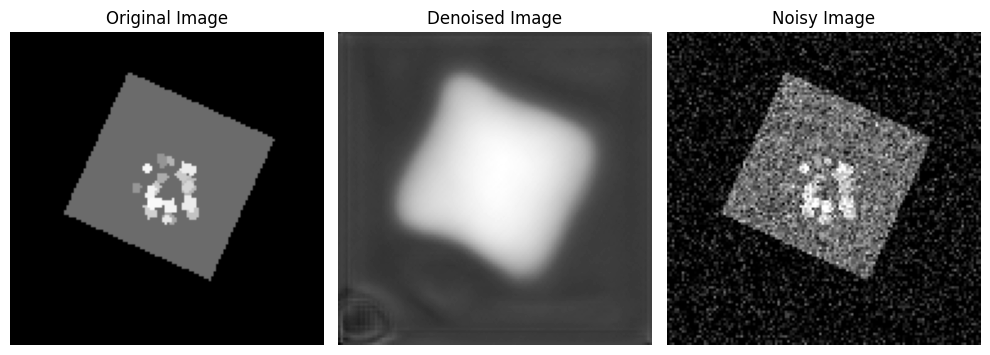

In [22]:

# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=100,
                num_iter=50,
                lr=0.00005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            # callbacks=[early_stop_callback],
            max_epochs=160, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=False,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

In [21]:
exported_arch = experiment.export_top_models()[0]

exported_arch

{'model_1/op_1_0': '1',
 'model_1/op_1_1': '1',
 'model_1/input_1_0': 0,
 'model_1/input_1_1': 0,
 'model_2/op_1_0': '2',
 'model_2/op_1_1': '2',
 'model_2/input_1_0': 0,
 'model_2/input_1_1': 0,
 'model_3/op_1_0': '1',
 'model_3/op_1_1': '1',
 'model_3/input_1_0': 0,
 'model_3/input_1_1': 0,
 'model_4/op_1_0': '5',
 'model_4/op_1_1': '2',
 'model_4/input_1_0': 0,
 'model_4/input_1_1': 0,
 'model_5/op_1_0': '0',
 'model_5/op_1_1': '0',
 'model_5/input_1_0': 0,
 'model_5/input_1_1': 0,
 'model_6/op_1_0': '3',
 'model_6/op_1_1': '3',
 'model_6/input_1_0': 0,
 'model_6/input_1_1': 0,
 'model_7/op_1_0': '0',
 'model_7/op_1_1': '0',
 'model_7/input_1_0': 0,
 'model_7/input_1_1': 0,
 'model_8/op_1_0': '0',
 'model_8/op_1_1': '0',
 'model_8/input_1_0': 0,
 'model_8/input_1_1': 0,
 'model_9/op_1_0': '0',
 'model_9/op_1_1': '0',
 'model_9/input_1_0': 0,
 'model_9/input_1_1': 0,
 'model_10/op_1_0': '3',
 'model_10/op_1_1': '3',
 'model_10/input_1_0': 0,
 'model_10/input_1_1': 0,
 'model_11/op_1_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 209 M 
----------------------------------------------
209 M     Trainable params
0         Non-trainable params
209 M     Total params
837.594   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[2023-08-23 07:46:25] Intermediate result: {"Iteration": 0, "variance": 0.7506289666891098, "loss": 0.3158620595932007}  (Index 7576)
[2023-08-23 07:46:25] Intermediate result: {"Iteration": 0, "variance": 0.7323961472855165, "loss": 0.3158990740776062}  (Index 7577)
[2023-08-23 07:46:26] Intermediate result: {"Iteration": 0, "variance": 0.7106762579469769, "loss": 0.19682243466377258}  (Index 7578)
[2023-08-23 07:46:26] Intermediate result: {"Iteration": 0, "variance": 0.6901335217324751, "loss": 0.19675742089748383}  (Index 7579)
[2023-08-23 07:46:26] Intermediate result: {"Iteration": 0, "variance": 0.6669356569262415, "loss": 0.06123610585927963}  (Index 7580)
[2023-08-23 07:46:27] Intermediate result: {"Iteration": 0, "variance": 0.6452455221985777, "loss": 0.06127869710326195}  (Index 7581)
[2023-08-23 07:46:27] Intermediate result: {"Iteration": 0, "variance": 0.6255506566094775, "loss": 0.05163613334298134}  (Index 7582)
[2023-08-23 07:46:27] Intermediate result: {"Iteration": 

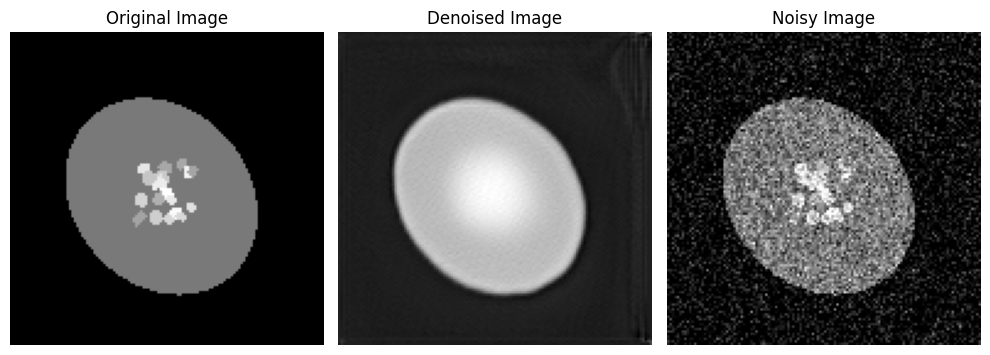

In [26]:

# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=50,
                num_iter=25,
                lr=0.005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            # callbacks=[early_stop_callback],
            max_epochs=250, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=False,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 209 M 
----------------------------------------------
209 M     Trainable params
0         Non-trainable params
209 M     Total params
837.594   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[2023-08-23 07:57:09] Intermediate result: {"Iteration": 0, "variance": 0.4831810675561428, "loss": 0.12135814875364304}  (Index 8388)
[2023-08-23 07:57:09] Intermediate result: {"Iteration": 0, "variance": 0.46876867745931333, "loss": 0.12128481268882751}  (Index 8389)
[2023-08-23 07:57:09] Intermediate result: {"Iteration": 0, "variance": 0.4552403696709209, "loss": 0.12360657006502151}  (Index 8390)
[2023-08-23 07:57:10] Intermediate result: {"Iteration": 0, "variance": 0.442412950763745, "loss": 0.1235693022608757}  (Index 8391)
[2023-08-23 07:57:10] Intermediate result: {"Iteration": 0, "variance": 0.4287203095596412, "loss": 0.0736498013138771}  (Index 8392)
[2023-08-23 07:57:11] Intermediate result: {"Iteration": 0, "variance": 0.41583948470652105, "loss": 0.0736086368560791}  (Index 8393)
[2023-08-23 07:57:11] Intermediate result: {"Iteration": 0, "variance": 0.40278598029286633, "loss": 0.03411884605884552}  (Index 8394)
[2023-08-23 07:57:11] Intermediate result: {"Iteration":

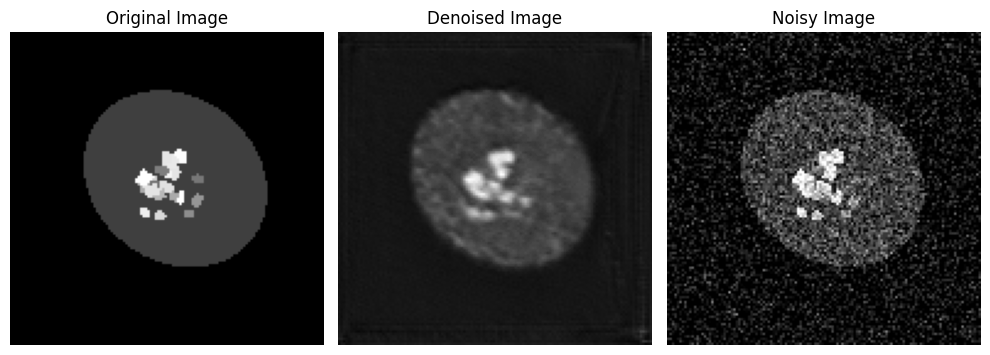

In [29]:

# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=50,
                num_iter=25,
                lr=0.005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            # callbacks=[early_stop_callback],
            max_epochs=350, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=False,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)